In [28]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import statistics

from statsmodels.stats import inter_rater as irr
from typing import *

In [61]:
import warnings
warnings.filterwarnings('ignore')

In [62]:
directory = "/Users/Millicent/Research/biomed-generation-analysis/biomed-generation-out"

In [63]:
results = {}

for path, _, files in os.walk(directory):
    for idx, file in enumerate(files):
        if file == ".DS_Store":
            continue
        else:
            final_path = os.path.join(path, file)
            data = []
            with open(final_path, "r") as f:
                for line in f:
                    data.append(json.loads(line))
            results[idx] = data

In [64]:
doc_idx = {}
for idx in range(10):
    doc_idx[idx + 1] = []

In [65]:
# Number of documents: should be 1 per person, times 4
for result in results:
    output = results[result][0]
    for question in output:
        doc_idx[question['data']['doc_idx']].append(question)

In [66]:
# Sanity check
for idx in doc_idx:
    assert len(doc_idx[idx]) == len(results)

In [53]:
# Aggregate headers for pandas
headers = ['doc_idx', 'completed_by', 'abstract', 'key_result', 'summary', 'plain_summary']
for idx in doc_idx:
    documents = doc_idx[idx]
    for document in documents:
        for doc in document['annotations'][0]['result']:
            headers.append(doc['from_name'])
        break
    break

In [54]:
df = pd.DataFrame(columns=headers)
df['completed_by'] = df['completed_by'].astype(int)

In [55]:
for idx in doc_idx:
    documents = doc_idx[idx]
    for document in documents:
        data = {
            'doc_idx' : idx,
            'completed_by' : int(document['annotations'][0]['completed_by']),
            'abstract' : document['data']['abstract'],
            'key_result' : document['data']['text'],
            'summary' : document['data']['summary'],
            'plain_summary' : document['data']['plain_summary']
        }
        doc = document['annotations'][0]['result']
        for doc in document['annotations'][0]['result']:
            try:
                data[doc['from_name']] = doc['value']['choices']
            except:
                data[doc['from_name']] = doc['value']
        df = df.append(data, ignore_index=True)

In [67]:
df_copy = df.copy(deep=True)

In [56]:
unwanted_headers = ['doc_idx', 'completed_by', 'abstract', 'key_result', 'summary', 'plain_summary']
headers_of_interest = [header for header in headers if header not in unwanted_headers]

In [94]:
likert_rating = ["Strongly disagree", "Disagree", "Agree", "Strongly agree"]
technical_terms_rating = ["None at all", "Only a few", "Mostly all", "All"]
omissions_rating = ["No ommision", "Minor omission(s)", "Major omission(s)"]
errors_rating = ["No errors", "Minor error", "Major error"]
likert_rating_dict = {s : idx for idx, s in enumerate(likert_rating)}
technical_terms_rating_dict = {s : idx for idx, s in enumerate(technical_terms_rating)}
omission_rating_dict = {s : idx for idx, s in enumerate(omissions_rating)}
errors_rating_dict = {s : idx for idx, s in enumerate(errors_rating)}

population_rating = [
    "The population is not mentioned (missing) in the model summary",
    "The population is mentioned, but described completely inaccurately",
    "The population is mentioned, but described somewhat inaccurately",
    "The population is mentioned, but somewhat underspecified",
    "The population is mentioned, and described accurately",
    "Not applicable (N/A)"
]
intervention_rating = [
    "The intervention is not mentioned (missing) in the model summary",
    "The intervention is mentioned, but described completely inaccurately",
    "The intervention is mentioned, but described somewhat inaccurately",
    "The intervention is mentioned, but somewhat underspecified",
    "The intervention is mentioned, and described accurately",
    "Not applicable (N/A)"
]
outcome_rating = [
    "The outcome is not mentioned (missing) in the model summary",
    "The outcome is mentioned, but described completely inaccurately",
    "The outcome is mentioned, but described somewhat inaccurately",
    "The outcome is mentioned, but somewhat underspecified",
    "The outcome is mentioned, and described accurately",
    "Not applicable (N/A)"
]

population_rating_plain = [
    "The population is not mentioned (missing) in the simplified model text",
    "The population is mentioned, but described completely inaccurately",
    "The population is mentioned, but described somewhat inaccurately",
    "The population is mentioned, but somewhat underspecified",
    "The population is mentioned, and described accurately",
    "Not applicable (N/A)"
]
intervention_rating_plain = [
    "The intervention is not mentioned (missing) in the simplified model text",
    "The intervention is mentioned, but described completely inaccurately",
    "The intervention is mentioned, but described somewhat inaccurately",
    "The intervention is mentioned, but somewhat underspecified",
    "The intervention is mentioned, and described accurately",
    "Not applicable (N/A)"
]
outcome_rating_plain = [
    "The outcome is not mentioned (missing) in the simplified model text",
    "The outcome is mentioned, but described completely inaccurately",
    "The outcome is mentioned, but described somewhat inaccurately",
    "The outcome is mentioned, but somewhat underspecified",
    "The outcome is mentioned, and described accurately",
    "Not applicable (N/A)"
]
population_rating_dict = {s : idx for idx, s in enumerate(population_rating)}
intervention_rating_dict = {s : idx for idx, s in enumerate(intervention_rating)}
outcome_rating_dict = {s : idx for idx, s in enumerate(outcome_rating)}

population_rating_plain_dict = {s : idx for idx, s in enumerate(population_rating_plain)}
intervention_rating_plain_dict = {s : idx for idx, s in enumerate(intervention_rating_plain)}
outcome_rating_plain_dict = {s : idx for idx, s in enumerate(outcome_rating_plain)}

In [95]:
rating_mapping = {
    'containsKeyResult' : likert_rating_dict,
    'population' : population_rating_dict,
    'intervention' : intervention_rating_dict,
    'outcome' : outcome_rating_dict,
    'omissions' : omission_rating_dict,
    'errors' : errors_rating_dict,
    'coherence' : likert_rating_dict,
    'usefulness' : likert_rating_dict,
    'containsKeyResult_plain' : likert_rating_dict,
    'population_plain' : population_rating_plain_dict,
    'intervention_plain' : intervention_rating_plain_dict,
    'outcome_plain' : outcome_rating_plain_dict,
    'omissions_plain' : omission_rating_dict,
    'errors_plain' : errors_rating_dict,
    'coherence_plain' : likert_rating_dict,
    'readability_plain' : likert_rating_dict,
    'substitution_plain' : technical_terms_rating_dict,
    'usefulness_plain' : likert_rating_dict,
}

In [98]:
likert_rating_dict_collapsed = {}
for idx, s in enumerate(likert_rating):
    if s == "Strongly disagree" or s == "Disagree":
        likert_rating_dict_collapsed[s] = 0
    elif s == "Strongly agree" or s == "Agree":
        likert_rating_dict_collapsed[s] = 1
    else:
        likert_rating

rating_mapping_collapsed = {
    'containsKeyResult' : likert_rating_dict_collapsed,
    'population' : population_rating_dict,
    'intervention' : intervention_rating_dict,
    'outcome' : outcome_rating_dict,
    'omissions' : omission_rating_dict,
    'errors' : errors_rating_dict,
    'coherence' : likert_rating_dict_collapsed,
    'usefulness' : likert_rating_dict_collapsed,
    'containsKeyResult_plain' : likert_rating_dict_collapsed,
    'population_plain' : population_rating_plain_dict,
    'intervention_plain' : intervention_rating_plain_dict,
    'outcome_plain' : outcome_rating_plain_dict,
    'omissions_plain' : omission_rating_dict,
    'errors_plain' : errors_rating_dict,
    'coherence_plain' : likert_rating_dict_collapsed,
    'readability_plain' : likert_rating_dict_collapsed,
    'substitution_plain' : technical_terms_rating_dict,
    'usefulness_plain' : likert_rating_dict_collapsed,
}

In [99]:
headers_of_interest

['containsKeyResult',
 'population',
 'intervention',
 'outcome',
 'omissions',
 'errors',
 'coherence',
 'usefulness',
 'containsKeyResult_plain',
 'population_plain',
 'intervention_plain',
 'outcome_plain',
 'omissions_plain',
 'errors_plain',
 'coherence_plain',
 'readability_plain',
 'substitution_plain',
 'usefulness_plain']

In [132]:
# Functions for analysis
def get_by_doc_idx(df, id: int) -> pd.DataFrame:
    return df.loc[df['doc_idx'] == id]

def get_distribution(df: pd.DataFrame, column: str) -> Union[List[str], List[str], List[str]]:
    df_curr = df.loc[:, column]
    ratings = rating_mapping[column]
    labels = df_curr.to_numpy()
    labels = [label[0] for label in labels]
    distribution = np.zeros(len(ratings))
    for label in labels:
        idx = ratings[label]
        distribution[idx] += 1
    return distribution, labels, ratings

def get_distribution_collapsed(df: pd.DataFrame, column: str) -> Union[List[str], List[str], List[str]]:
    df_curr = df.loc[:, column]
    ratings = rating_mapping_collapsed[column]
    labels = df_curr.to_numpy()
    labels = [label[0] for label in labels]
    max_idx = max(ratings[key] for key in ratings)
    distribution = np.zeros(max_idx + 1)
    for label in labels:
        idx = ratings[label]
        distribution[idx] += 1
    return distribution, labels, ratings

# SHOULD BE SUBJECT/SAMPLE x RATER AS THE RETURN RESULT -- ACROSS ONE TYPE OF COLUMN
# Assigning a # means the assigned category
# From https://stackoverflow.com/a/70117023
def get_sample_by_choice(df: pd.DataFrame, column: str) -> List[str]:
    ratings = rating_mapping[column]
    max_doc_idx = 10
    output = []
    for idx in range(max_doc_idx):
        docs = get_by_doc_idx(df, idx + 1)
        # Get the column we want now for this specific doc_idx (doc 1, doc 2, doc 3, etc)
        df_curr = docs.loc[:, column]
        labels = df_curr.to_numpy()
        labels = [label[0] for label in labels]
        distribution = np.zeros(len(df_curr))
        for i, label in enumerate(labels):
            distribution[i] = ratings[label]
        output.append(distribution)

    return np.array(output)

def plot_distributions_and_all(df: pd.DataFrame, columns: List[str]) -> None:
    for idx, column in enumerate(columns):
        distribution, _, ratings = get_distribution(df, column)
        variance, mean, stddev = get_statistics(distribution)
        kappa = get_fleiss_kappa(df, column)
        print(f"Statistics for {column}:\n    Variance: {variance}\n    Mean: {mean}\n    Std Dev: {stddev}\n    Fleiss Kappa: {kappa}")
        # fig, axs = plt.subplots(1, 18, figsize=(15,15))
        x = np.arange(len(distribution))
        y = np.arange(int(max(distribution)))
        # print("Here's x:", x)
        # print("Here's y:", y)
        # x_index = idx % 9
        # y_index = int(idx // 9)
        ratings_as_labels = [key for key in ratings]
        plt.bar(ratings_as_labels, distribution)
        # plt.xticks(labels)
        plt.xticks(rotation = 90)
        plt.yticks(y)
        plt.title(column)
        plt.xlabel("Agreement Type")
        plt.ylabel("Frequency")

        # print("Here's x_index:", x_index)
        # print("Here's y_index:", y_index)
        # print()
        # axs[x_index, y_index].set_xticks(x)
        # axs[x_index, y_index].set_yticks(y)
        # axs[x_index, y_index].set_xticklabels("Agreement Type")
        # axs[x_index, y_index].set_yticklabels("Frequency")
        # axs[x_index, y_index].bar(x, distribution)
        # axs[x_index, y_index].title(column)
        # axs[idx].set_xticks(x)
        # axs[idx].set_yticks(y)
        # axs[idx].set_xticklabels("Agreement Type")
        # axs[idx].set_yticklabels("Frequency")
        # axs[idx].bar(x, distribution)
        # axs[idx].title(column)
        plt.show()

def plot_distributions_and_all_collapsed(df: pd.DataFrame, columns: List[str]) -> None:
    for idx, column in enumerate(columns):
        print("Column:", column)
        distribution, _, ratings = get_distribution_collapsed(df, column)
        print("Here's distribution:", distribution)
        variance, mean, stddev = get_statistics(distribution)
        kappa = get_fleiss_kappa(df, column)
        print(f"Statistics for {column}:\n    Variance: {variance}\n    Mean: {mean}\n    Std Dev: {stddev}\n    Fleiss Kappa: {kappa}")
        # fig, axs = plt.subplots(1, 18, figsize=(15,15))
        x = np.arange(len(distribution))
        y = np.arange(int(max(distribution)))
        ratings_as_labels = [key for key in ratings]
        print("Ratings as labels:", ratings_as_labels)
        ratings = []
        for key in ratings_as_labels:
            if key == "Strongly agree" or key == "Strongly disagree":
                continue
            else:
                ratings.append(key)

        ratings_as_labels = ratings
        print("Here's ratings_as_labels:", ratings_as_labels)
        print("Here's distribution", distribution)
        plt.bar(ratings_as_labels, distribution)
        plt.xticks(rotation = 90)
        plt.yticks(y)
        plt.title(column)
        plt.xlabel("Agreement Type")
        plt.ylabel("Frequency")
        plt.show()

def get_fleiss_kappa(df: pd.DataFrame, column: List[str]):
    """
    Some information on kappas:
    Null Hypothesis Kappa = 0	Agreement is due to chance
    0.01-0.020	Slight agreement
    0.21-0.40	Fair Agreement
    0.41-0.60	Moderate Agreement
    0.61-0.80	Substantial Agreement
    0.81-1.00	Almost Perfect Agreement
    Negative (Kappa<0)	Agreement less than that expected by chance
    """
    # Should be subject/sample x rater
    distribution = get_sample_by_choice(df, column)
    # Should be subject/sample x cat counts
    aggregated = irr.aggregate_raters(distribution)
    
    # Debug prints
    # print("Here's distribution:", distribution)
    # print("Here's aggregated:", aggregated)
    return irr.fleiss_kappa(aggregated[0], method='fleiss')


def get_statistics(distribution: List[int]) -> Union[float, float]:
    values_per_label = []
    for idx, d in enumerate(distribution):
        l = [idx for _ in range(int(d))]
        values_per_label.extend(l)

    return statistics.variance(values_per_label), \
            statistics.mean(values_per_label), \
            statistics.stdev(values_per_label)

Column: containsKeyResult
Here's distribution: [14. 36.]
Statistics for containsKeyResult:
    Variance: 0.2057142857142857
    Mean: 0.72
    Std Dev: 0.4535573676110727
    Fleiss Kappa: 0.01620370370370361
Ratings as labels: ['Strongly disagree', 'Disagree', 'Agree', 'Strongly agree']
Here's ratings_as_labels: ['Disagree', 'Agree']
Here's distribution [14. 36.]


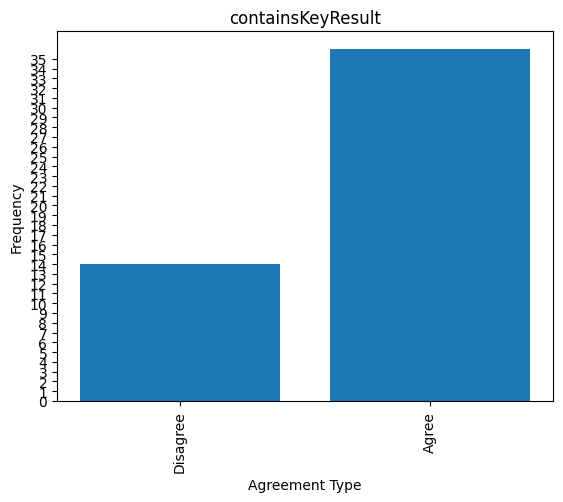

Column: population
Here's distribution: [11.  0.  1. 15. 23.  0.]
Statistics for population:
    Variance: 2.460816326530612
    Mean: 2.78
    Std Dev: 1.568698927943349
    Fleiss Kappa: 0.30726600985221686
Ratings as labels: ['The population is not mentioned (missing) in the model summary', 'The population is mentioned, but described completely inaccurately', 'The population is mentioned, but described somewhat inaccurately', 'The population is mentioned, but somewhat underspecified', 'The population is mentioned, and described accurately', 'Not applicable (N/A)']
Here's ratings_as_labels: ['The population is not mentioned (missing) in the model summary', 'The population is mentioned, but described completely inaccurately', 'The population is mentioned, but described somewhat inaccurately', 'The population is mentioned, but somewhat underspecified', 'The population is mentioned, and described accurately', 'Not applicable (N/A)']
Here's distribution [11.  0.  1. 15. 23.  0.]


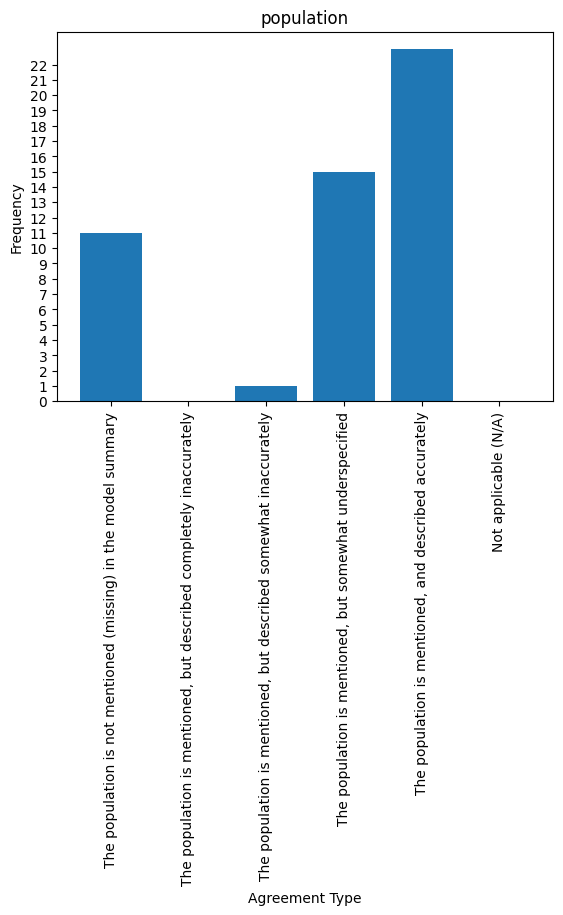

Column: intervention
Here's distribution: [ 1.  1.  1. 17. 30.  0.]
Statistics for intervention:
    Variance: 0.6628571428571429
    Mean: 3.48
    Std Dev: 0.8141603913585719
    Fleiss Kappa: -0.03211009174311912
Ratings as labels: ['The intervention is not mentioned (missing) in the model summary', 'The intervention is mentioned, but described completely inaccurately', 'The intervention is mentioned, but described somewhat inaccurately', 'The intervention is mentioned, but somewhat underspecified', 'The intervention is mentioned, and described accurately', 'Not applicable (N/A)']
Here's ratings_as_labels: ['The intervention is not mentioned (missing) in the model summary', 'The intervention is mentioned, but described completely inaccurately', 'The intervention is mentioned, but described somewhat inaccurately', 'The intervention is mentioned, but somewhat underspecified', 'The intervention is mentioned, and described accurately', 'Not applicable (N/A)']
Here's distribution [ 1.  1

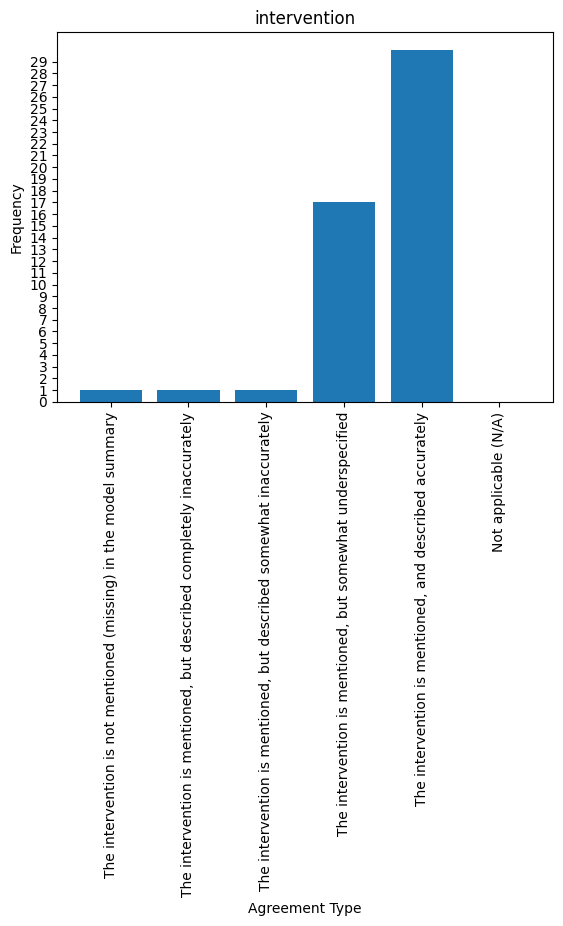

Column: outcome
Here's distribution: [ 1.  0.  6. 17. 26.  0.]
Statistics for outcome:
    Variance: 0.7187755102040817
    Mean: 3.34
    Std Dev: 0.8478062928547309
    Fleiss Kappa: 0.04873164218958603
Ratings as labels: ['The outcome is not mentioned (missing) in the model summary', 'The outcome is mentioned, but described completely inaccurately', 'The outcome is mentioned, but described somewhat inaccurately', 'The outcome is mentioned, but somewhat underspecified', 'The outcome is mentioned, and described accurately', 'Not applicable (N/A)']
Here's ratings_as_labels: ['The outcome is not mentioned (missing) in the model summary', 'The outcome is mentioned, but described completely inaccurately', 'The outcome is mentioned, but described somewhat inaccurately', 'The outcome is mentioned, but somewhat underspecified', 'The outcome is mentioned, and described accurately', 'Not applicable (N/A)']
Here's distribution [ 1.  0.  6. 17. 26.  0.]


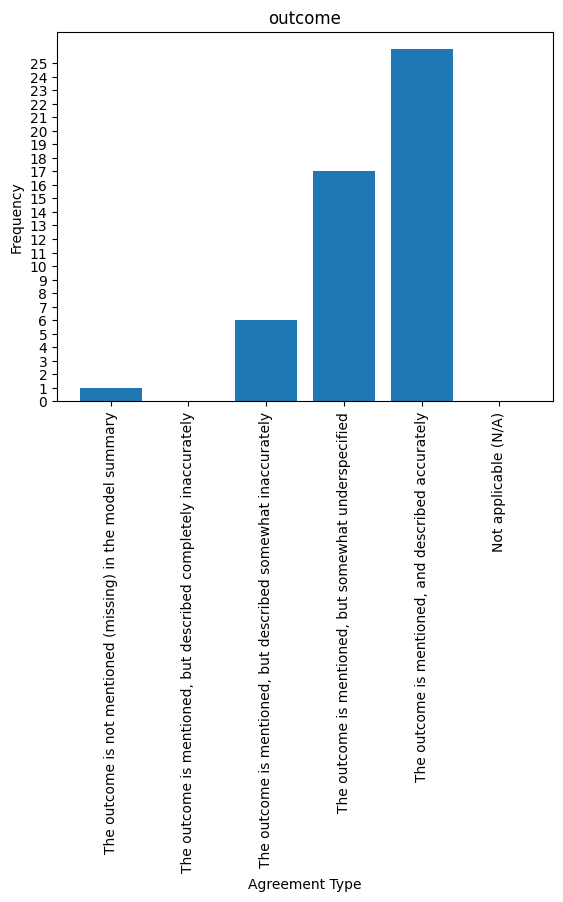

Column: omissions
Here's distribution: [15. 21. 14.]
Statistics for omissions:
    Variance: 0.5914285714285714
    Mean: 0.98
    Std Dev: 0.7690439333539869
    Fleiss Kappa: 0.00793650793650791
Ratings as labels: ['No ommision', 'Minor omission(s)', 'Major omission(s)']
Here's ratings_as_labels: ['No ommision', 'Minor omission(s)', 'Major omission(s)']
Here's distribution [15. 21. 14.]


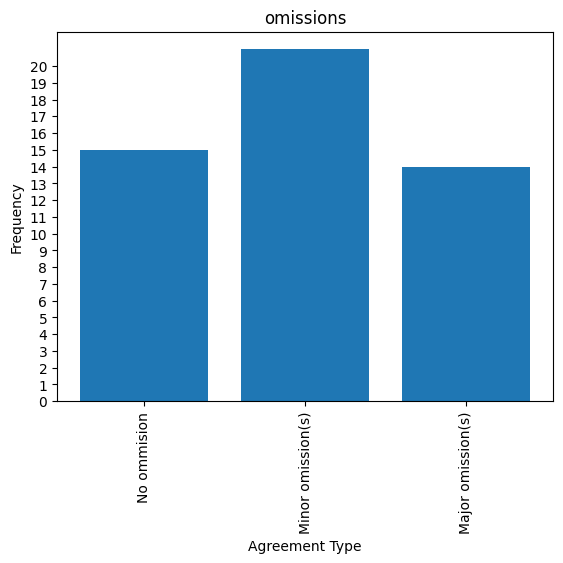

Column: errors
Here's distribution: [42.  5.  3.]
Statistics for errors:
    Variance: 0.2975510204081633
    Mean: 0.22
    Std Dev: 0.5454823740581938
    Fleiss Kappa: -0.06837606837606834
Ratings as labels: ['No errors', 'Minor error', 'Major error']
Here's ratings_as_labels: ['No errors', 'Minor error', 'Major error']
Here's distribution [42.  5.  3.]


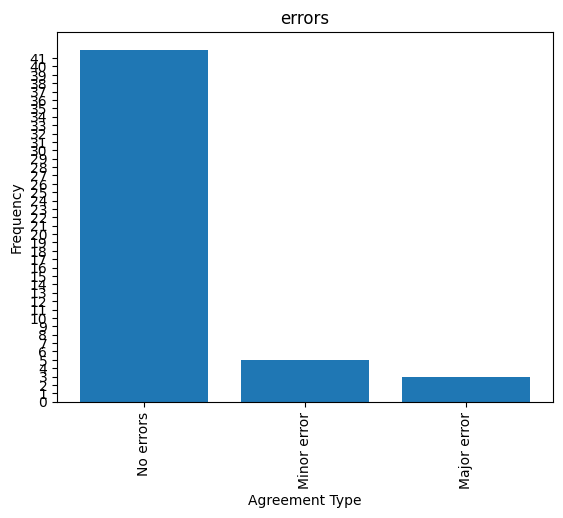

Column: coherence
Here's distribution: [ 0.  2.  5. 43.]
Statistics for coherence:
    Variance: 0.23224489795918368
    Mean: 2.82
    Std Dev: 0.4819179369552286
    Fleiss Kappa: -0.004823151125401844
Ratings as labels: ['Strongly disagree', 'Disagree', 'Agree', 'Strongly agree']
Here's ratings_as_labels: ['Disagree', 'Agree']
Here's distribution [ 0.  2.  5. 43.]


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (2,) and arg 1 with shape (4,).

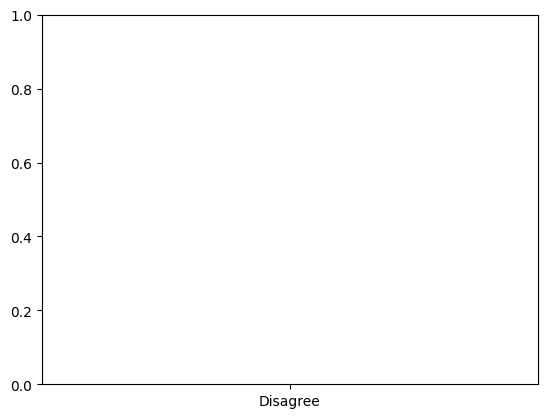

In [133]:
plot_distributions_and_all_collapsed(df_copy, headers_of_interest)

Statistics for containsKeyResult:
    Variance: 0.9371428571428572
    Mean: 2.04
    Std Dev: 0.9680613912055667
    Fleiss Kappa: 0.01620370370370361


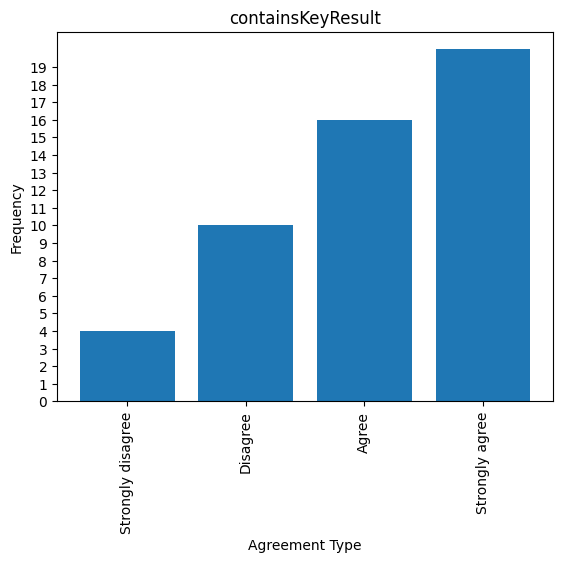

Statistics for population:
    Variance: 2.460816326530612
    Mean: 2.78
    Std Dev: 1.568698927943349
    Fleiss Kappa: 0.30726600985221686


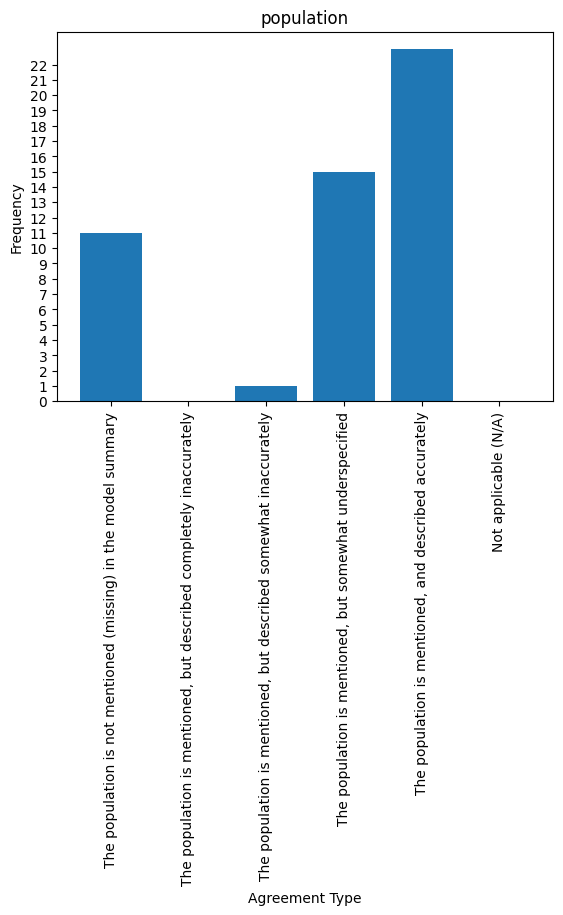

Statistics for intervention:
    Variance: 0.6628571428571429
    Mean: 3.48
    Std Dev: 0.8141603913585719
    Fleiss Kappa: -0.03211009174311912


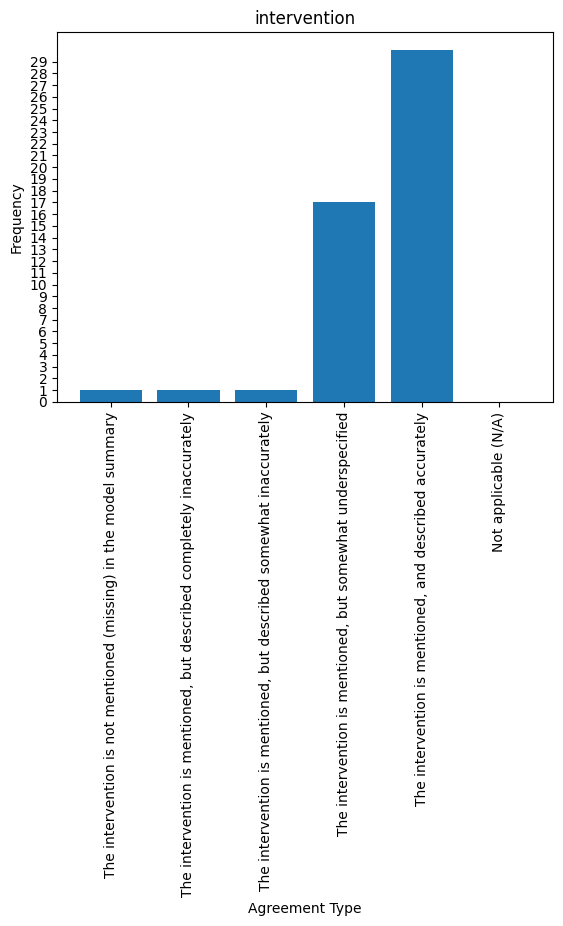

Statistics for outcome:
    Variance: 0.7187755102040817
    Mean: 3.34
    Std Dev: 0.8478062928547309
    Fleiss Kappa: 0.04873164218958603


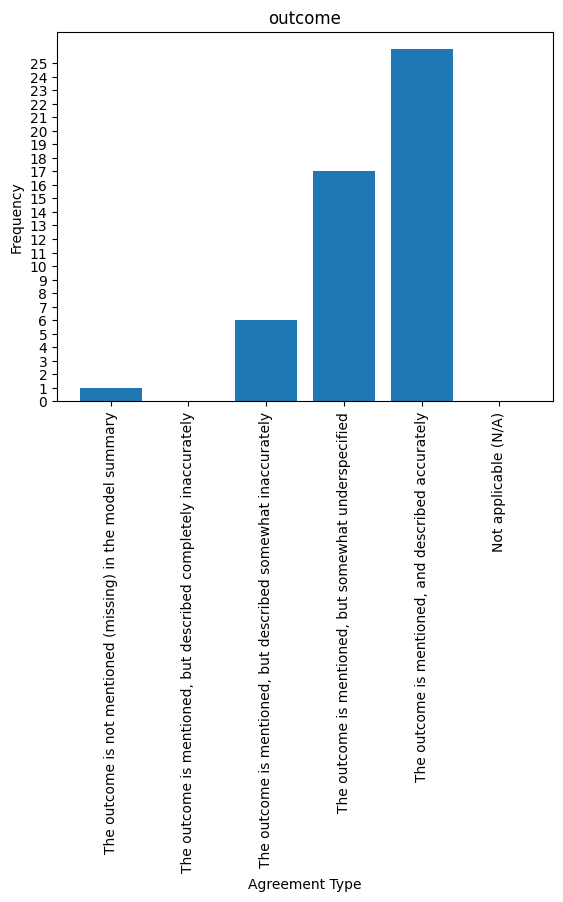

Statistics for omissions:
    Variance: 0.5914285714285714
    Mean: 0.98
    Std Dev: 0.7690439333539869
    Fleiss Kappa: 0.00793650793650791


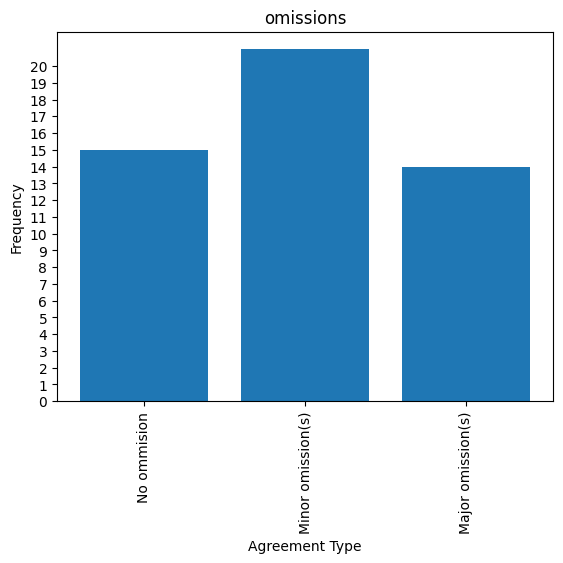

Statistics for errors:
    Variance: 0.2975510204081633
    Mean: 0.22
    Std Dev: 0.5454823740581938
    Fleiss Kappa: -0.06837606837606834


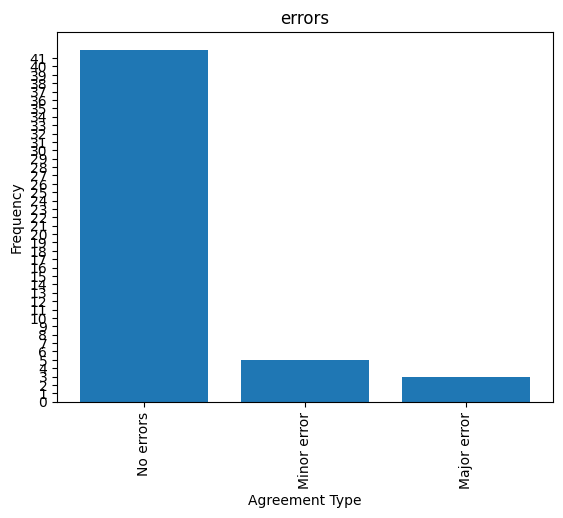

Statistics for coherence:
    Variance: 0.23224489795918368
    Mean: 2.82
    Std Dev: 0.4819179369552286
    Fleiss Kappa: -0.004823151125401844


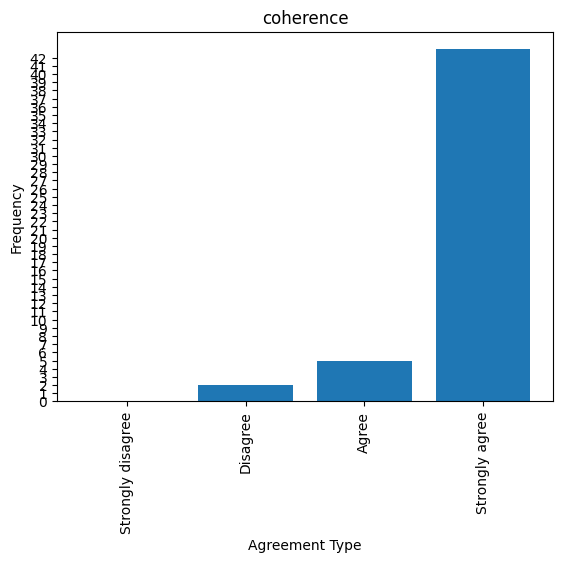

Statistics for usefulness:
    Variance: 0.6404081632653061
    Mean: 2.18
    Std Dev: 0.8002550613806239
    Fleiss Kappa: 0.10383189122373297


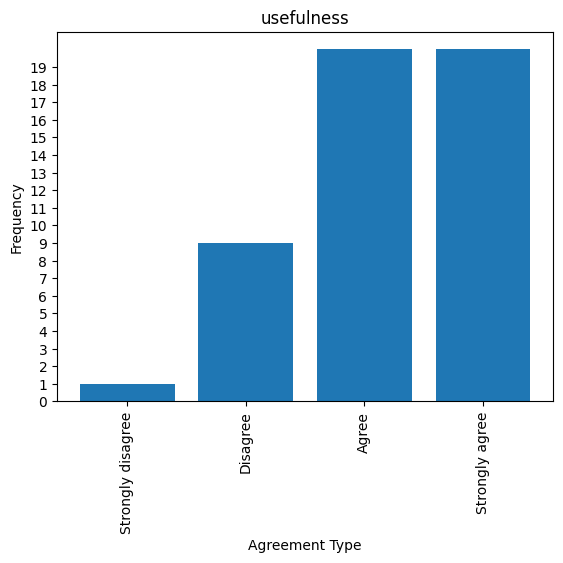

Statistics for containsKeyResult_plain:
    Variance: 0.9371428571428572
    Mean: 1.96
    Std Dev: 0.9680613912055667
    Fleiss Kappa: 0.11123853211009174


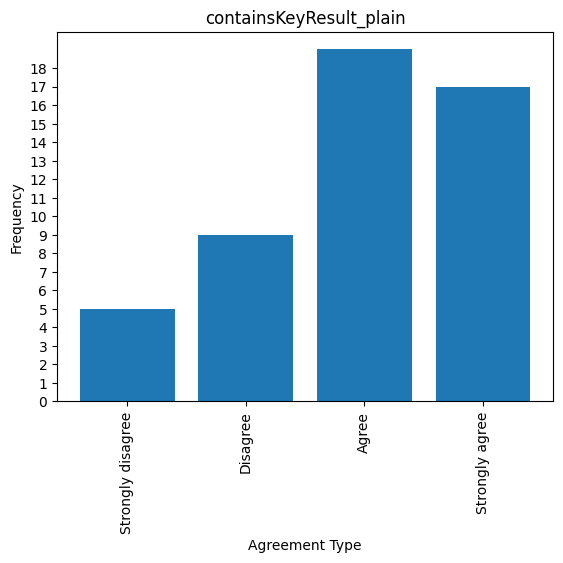

Statistics for population_plain:
    Variance: 2.704081632653061
    Mean: 2.7
    Std Dev: 1.6444092047459054
    Fleiss Kappa: 0.12790697674418608


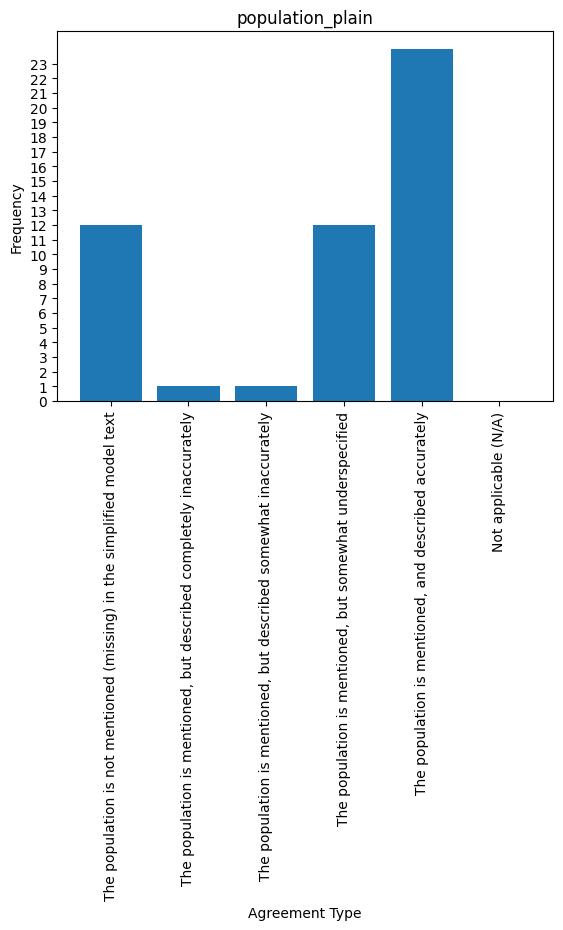

Statistics for intervention_plain:
    Variance: 0.9081632653061225
    Mean: 3.3
    Std Dev: 0.9529760045804524
    Fleiss Kappa: 0.16439290586630284


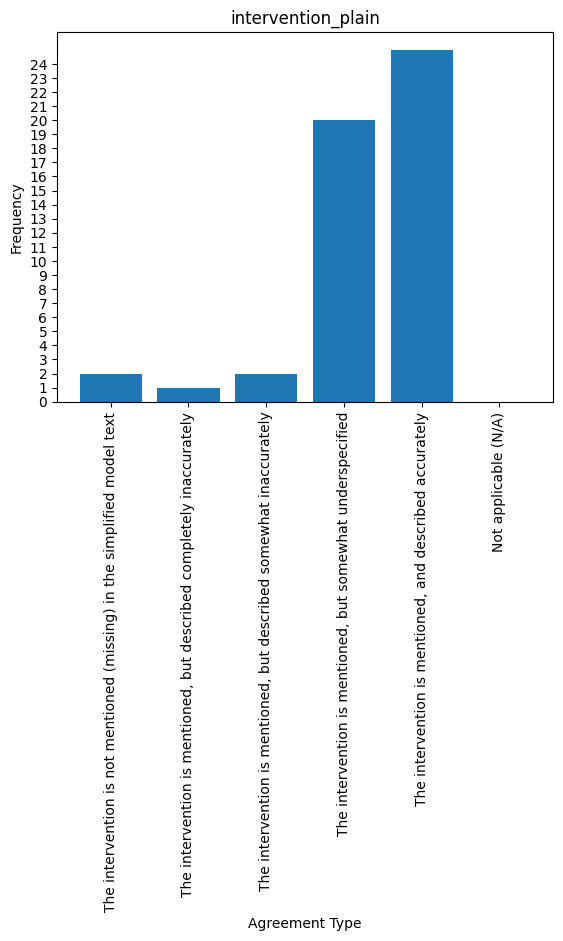

Statistics for outcome_plain:
    Variance: 0.6138775510204082
    Mean: 3.28
    Std Dev: 0.7835033829029765
    Fleiss Kappa: 0.2507309941520469


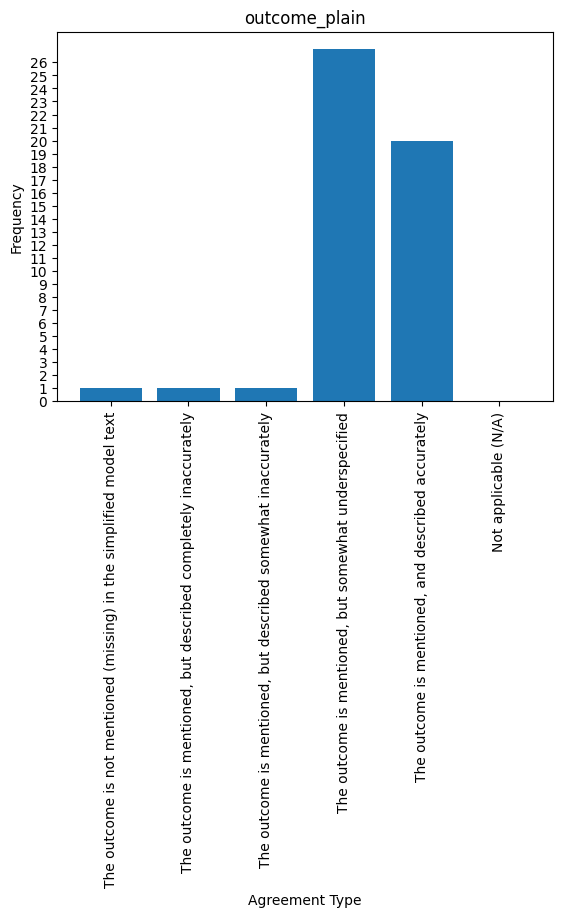

Statistics for omissions_plain:
    Variance: 0.6922448979591838
    Mean: 0.96
    Std Dev: 0.8320125587749164
    Fleiss Kappa: 0.12860576923076933


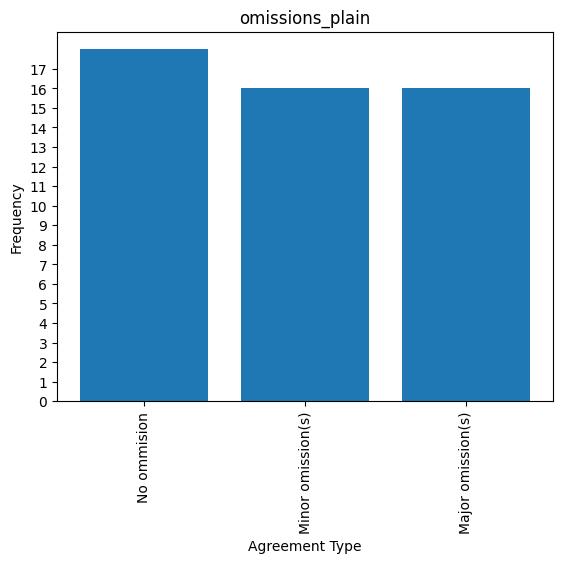

Statistics for errors_plain:
    Variance: 0.23020408163265305
    Mean: 0.12
    Std Dev: 0.4797958749641904
    Fleiss Kappa: -0.06382978723404142


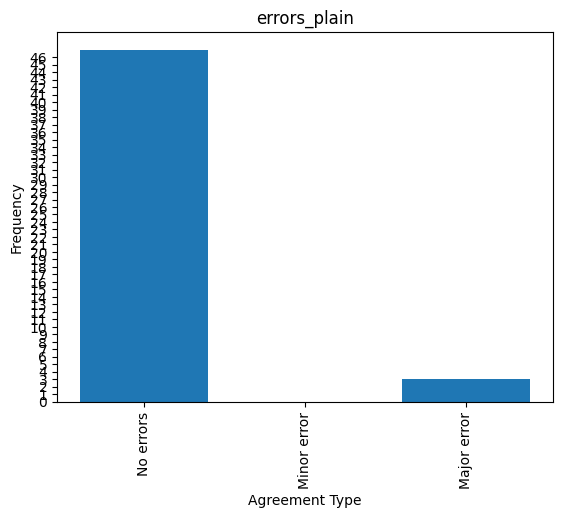

Statistics for coherence_plain:
    Variance: 0.19142857142857145
    Mean: 2.82
    Std Dev: 0.43752550946038726
    Fleiss Kappa: -0.05685131195335256


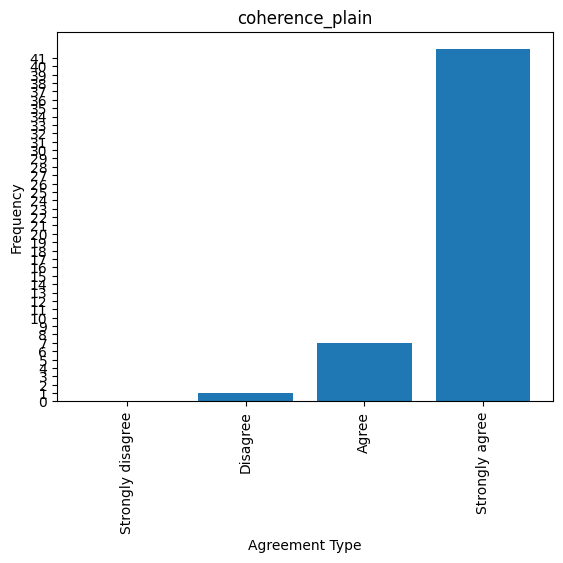

Statistics for readability_plain:
    Variance: 0.44448979591836735
    Mean: 2.62
    Std Dev: 0.6667006794044591
    Fleiss Kappa: 0.11202185792349731


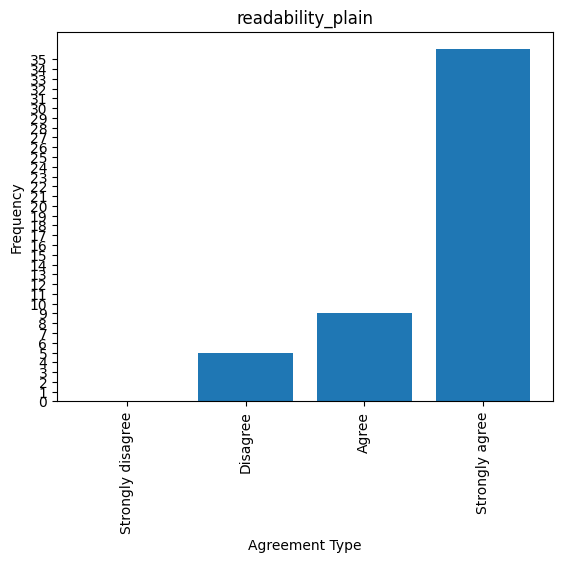

Statistics for substitution_plain:
    Variance: 0.6779591836734694
    Mean: 2.34
    Std Dev: 0.823382768627975
    Fleiss Kappa: 0.08412483039348699


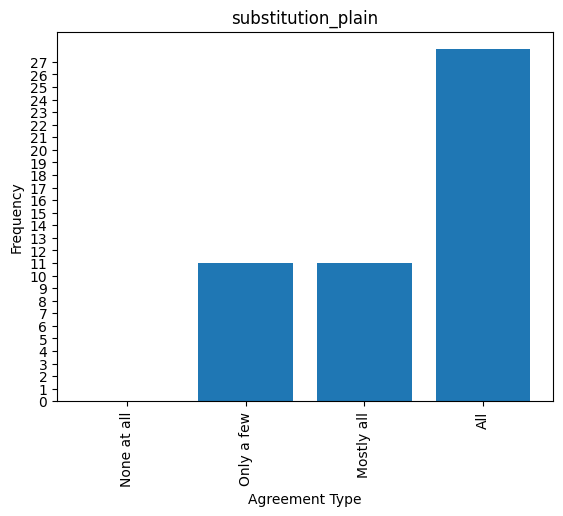

Statistics for usefulness_plain:
    Variance: 0.4489795918367347
    Mean: 2.2
    Std Dev: 0.6700593942604899
    Fleiss Kappa: -0.028138528138528043


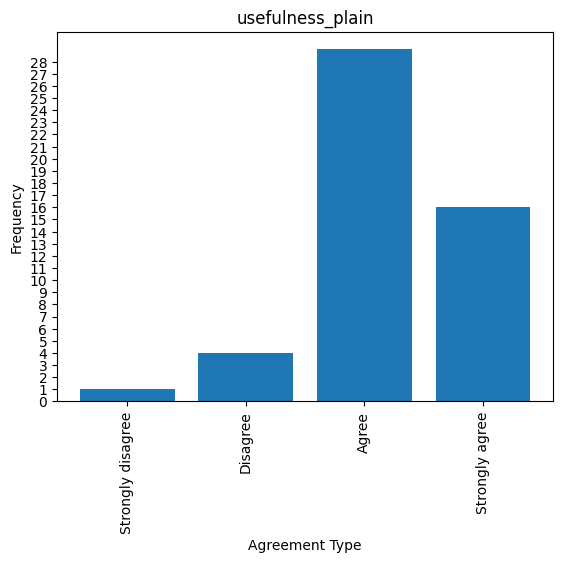

In [ ]:
plot_distributions_and_all(df, headers_of_interest)